Adapted from class assignment based on:
NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_



In [56]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Loading data files
==================


In [57]:
from google.colab import drive
drive.mount('/content/drive')

filepath_train = '/content/drive/My Drive/01UNCC_NLP/Project/data/x_train.csv'
filepath_test = '/content/drive/My Drive/01UNCC_NLP/Project/data/x_test.csv'
X_train = pd.read_csv(filepath_train)
X_test = pd.read_csv(filepath_test)
X_train['question'].tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1029    Can anyone explain to me how Italy was able to...
1030    How do you actually die from the coronavirus? ...
1031    Central Banks around the world have cut intere...
1032    Is it safe to buy fruit and veg, including sal...
1033    I saw a recent news article about President Tr...
Name: question, dtype: object

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [26]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [27]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [29]:
# Restrict to sentences with a max of 1000 words
MAX_LENGTH = 1000

In [30]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

The full process for preparing the data is:

-  Read text file and select question and answer columns
-  Make word lists from question and answer columns in pairs


In [31]:
def prepareData( ):
    input_len =[]
    output_len = []
    input_lang = Lang('question')
    output_lang = Lang('answer')
    pairs =[]
    print("Counting words...")
    for sent in range(1,1034):
        s0 = X_train['question'][sent]
        s1 = X_train['prep_answer'][sent]
        if (len(s0)<MAX_LENGTH) and (len(s1)<MAX_LENGTH):
          input_lang.addSentence(s0)
          output_lang.addSentence(s1)
          pairs.append([s0,s1])
        input_len.append(len(s0))
        output_len.append(len(s1))

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, input_len, output_len, pairs


input_lang, output_lang,input_len, output_len, pairs = prepareData()
toprint = random.choice(pairs)
print( toprint[1])

Counting words...
Counted words:
question 4813
answer 7627
symptoms show up 14 days after exposure to the virus.


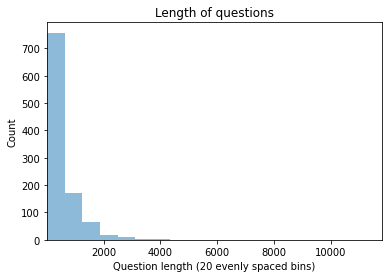

In [33]:
import numpy as np
import math
from matplotlib import pyplot as plt

data = input_len

bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   20) # fixed number of bins

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Length of questions')
plt.xlabel('Question length (20 evenly spaced bins)')
plt.ylabel('Count')

plt.show()

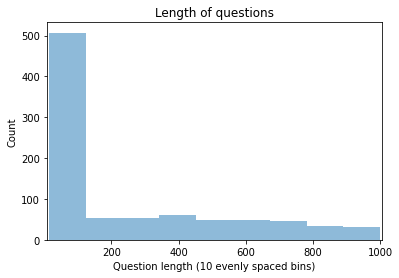

In [34]:
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(1000),
                   10) # fixed number of bins

plt.xlim([min(data)-5, 1000 +5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Length of questions')
plt.xlabel('Question length (10 evenly spaced bins)')
plt.ylabel('Count')

plt.show()

In [35]:
#showPlot(output_len)

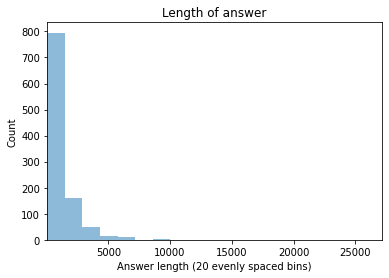

In [36]:
data = output_len

bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   20) # fixed number of bins

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Length of answer')
plt.xlabel('Answer length (20 evenly spaced bins)')
plt.ylabel('Count')

plt.show()

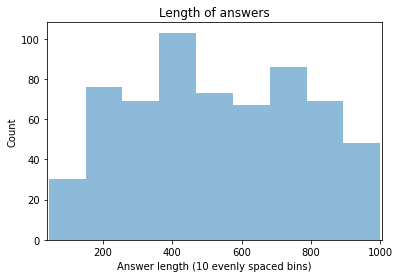

In [37]:
data = output_len
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(1000),
                   10) # fixed number of bins

plt.xlim([min(data)-5, 1000 +5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Length of answers')
plt.xlabel('Answer length (10 evenly spaced bins)')
plt.ylabel('Count')

plt.show()

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [39]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [40]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [41]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(input_sent,target_sent):
    input_tensor = tensorFromSentence(input_lang, input_sent)
    target_tensor = tensorFromSentence(output_lang, target_sent)
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.


In [42]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [43]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [50]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    pair = random.choice(pairs)
    training_pairs = [tensorsFromPair(pair[0], pair[1])
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [46]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [47]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        j = random.randint(0, 1033)
        input_sentence= X_train['question'][j]
        target_sentence = X_train['prep_answer'][j]
        print('>', input_sentence)
        print('=',target_sentence )
        output_words, attentions = evaluate(encoder, decoder, input_sentence )
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================
We trained using 256 hidden parameters. 
We have seen that the question and answers are long sentences, even in the 100s and 1000 range. 
**We see that the loss is not converging. We do not explore this model further**

In [51]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000)
#def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):

4m 20s (- 320m 57s) (1000 1%) 19.1478
8m 25s (- 307m 28s) (2000 2%) 16.7325
12m 28s (- 299m 30s) (3000 4%) 18.8077
16m 32s (- 293m 32s) (4000 5%) 20.5614
20m 36s (- 288m 26s) (5000 6%) 20.8609
24m 36s (- 283m 1s) (6000 8%) 21.2557
28m 37s (- 278m 1s) (7000 9%) 22.1815
32m 38s (- 273m 21s) (8000 10%) 23.0751
36m 41s (- 269m 1s) (9000 12%) 22.1497
40m 42s (- 264m 35s) (10000 13%) 20.9702
44m 33s (- 259m 17s) (11000 14%) 19.7013
48m 22s (- 253m 58s) (12000 16%) 19.7852
52m 18s (- 249m 27s) (13000 17%) 20.8751
56m 3s (- 244m 16s) (14000 18%) 20.9733
59m 54s (- 239m 37s) (15000 20%) 22.2354
63m 45s (- 235m 5s) (16000 21%) 21.5505
67m 36s (- 230m 40s) (17000 22%) 22.5639
71m 32s (- 226m 32s) (18000 24%) 22.7580
75m 27s (- 222m 25s) (19000 25%) 23.1439
79m 28s (- 218m 32s) (20000 26%) 24.8850
83m 27s (- 214m 35s) (21000 28%) 24.8512
87m 28s (- 210m 44s) (22000 29%) 25.2070
91m 23s (- 206m 38s) (23000 30%) 27.4745
95m 21s (- 202m 39s) (24000 32%) 28.3130
99m 19s (- 198m 39s) (25000 33%) 28.055

KeyboardInterrupt: ignored

In [52]:
evaluateRandomly(encoder1, attn_decoder1)

> The Wuhan coronavirus's genome was released, and is now available on Genbank.  Looking at it...


    1 attaaaggtt tataccttcc caggtaacaa accaaccaac tttcgatctc ttgtagatct
   61 gttctctaaa cgaactttaa aatctgtgtg gctgtcactc ggctgcatgc ttagtgcact
  121 cacgcagtat aattaataac taattactgt cgttgacagg acacgagtaa ctcgtctatc
  ...
29761 acagtgaaca atgctaggga gagctgccta tatggaagag ccctaatgtg taaaattaat
29821 tttagtagtg ctatccccat gtgattttaa tagcttctta ggagaatgac aaaaaaaaaa
29881 aaaaaaaaaa aaaaaaaaaa aaa

  
  Wuhan seafood market pneumonia virus isolate Wuhan-Hu-1, complete genome, Genbank


Geeze, that's a lot of a nucleotides---I don't think that's just random.  I would guess that it's either an artifact of the sequencing process, or there is some underlying biological reason.

Question: Why does the Wuhan coronavirus genome end in 33 a's?

= good observation  the 3  poly a  tail is actually a very common feature of positive-strand rna viruses, including coronaviruses and picornaviruses.  for c

KeyError: ignored